In [7]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io

# Functions for finding Modes

In [142]:
#Function that gives the real and imaginary part of the Fourier transform of psi at a given time and a given wavenumber k,l

def fft2d_RI(psi,k,l,Lx,nx,ny,time_tab):

    real_part_tab=np.zeros_like(time_tab,dtype=float)
    imag_part_tab=np.zeros_like(time_tab,dtype=float)
    #dx=Lx/nx/(2*np.pi)
    #dy=Lx/ny/(2*np.pi)
    dx = Lx / (nx)
    dy = Lx / (ny)

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
    
    #kx=np.fft.fftfreq(int(nx),d=dx)
    #ky=np.fft.fftfreq(int(ny),d=dy)
    kx_reshaped=np.zeros_like(kx)
    kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
    kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

    ky_reshaped=np.zeros_like(ky)
    ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
    ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

    Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
    Ky=np.flipud(Ky)
    

    for i,time_sel in enumerate(time_tab):

        psi_data=psi[time_sel,:,:]

        # 2D Fourier Transform
        fft_result = np.fft.fft2(psi_data[:,:])* dx**2 / (2 * np.pi)*1000
        fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center


        # Convert wavenumbers to indices
        # Find the index of the closest value to k in freqs_x
        k_index = np.argmin(np.abs(k - kx_reshaped))

        # Find the index of the closest value to l in freqs_y
        l_index = np.argmin(np.abs(l - ky_reshaped))
        
        
        # Extract the complex value at (k_index, l_index)
        complex_value = fft_shifted[l_index,k_index]

        # Get real and imaginary parts
        real_part_tab[i] = np.real(complex_value)
        imag_part_tab[i] = np.imag(complex_value)

        # Print the results
        #print(f"Complex value at (k, l) = ({k}, {l}): {complex_value}")
        #print(f"Real part: {real_part_tab[i]}")
        #print(f"Imaginary part: {imag_part_tab[i]}")

        #print("Amplitude",np.sqrt(real_part_tab[i]**2+imag_part_tab[i]**2))
    return real_part_tab,imag_part_tab



In [143]:
#Function to find the mode with the maximum amplitude

def find_mode_max_amplitude(psi,Lx,nx,ny,time_tab):

    k_max=np.pi*2 / (Lx/(nx-1))
    k_min=2*np.pi/(Lx)

    k_step=(k_max-k_min)/(nx)

    #Making the arrays of wavenumbers we try
    k_range = np.arange(0, k_max, k_step*2)
    #l_range = np.arange(k_min, k_max, k_step)
    print("len k_range",len(k_range))
    print("k_min",k_min)
    print("k_max",k_max)
    amplitude_max=0
    k_ampmax=0
    l_ampmax=0
    #Going through all the wavenumbers
    for k in k_range:
        for l in k_range:
            real,im=fft2d_RI(psi,k,l,Lx,nx,ny,time_tab)
            amplitude=np.sqrt(real[0]**2+im[0]**2)#*(1/(np.pi*2))
            if (amplitude > amplitude_max):
                amplitude_max=amplitude
                k_ampmax=k
                l_ampmax=l
    return k_ampmax,l_ampmax,amplitude_max

In [144]:
#function to determine the pulsation of the signal (omega=dteta/dt)
def pulsation(real_part_tab,imag_part_tab,t):
    """
    real_part_tab,imag_part_tab: array of the real part and imaginary part of the Fourier transform of psi of the wave isolated
    t: time array
    """
    arg_tab=np.arctan(imag_part_tab/real_part_tab)
    pulsation_observed=np.mean((arg_tab[1:]-arg_tab[0:-1])/(t[1]-t[0]))

    return pulsation_observed





In [145]:
#Finding the modes in the signal

def find_modes(psi_fft,freq_x,freq_y):
    # Get the amplitude of the Fourier components
    amplitude = np.abs(psi_fft)

    # Find the peak values (modes)
    # This part might need some fine-tuning based on your data
            
    threshold = np.max(amplitude) * 0.3  # example threshold
    modes = np.where(amplitude > threshold)
    print(np.shape(modes))
    # Extract the corresponding (k, l) values
    k_modes = freq_x[modes[0]]
    l_modes = freq_y[modes[1]]

    return k_modes, l_modes


# Test Lennard Wave

In [146]:
#Dataset of Lennard :

#Reading the netcdf file
dataset=nc.Dataset('wave.nc')
print(dataset.variables.keys())


psi_lennard=dataset.variables['__xarray_dataarray_variable__'][:,:,:]
t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]



nx=len(x)
ny=len(y)

k_max=np.pi*2/(x[1]-x[0])
k_min=2*np.pi/(x[-1]-x[0])

print("kmax=",k_max,"kmin=",k_min)

dx=x[1]-x[0]
dy=y[1]-y[0]
Lx=len(x)*dx

print(dx,dx*nx)


dict_keys(['__xarray_dataarray_variable__', 'time', 'x', 'y'])
kmax= 0.00015707963267948965 kmin= 1.5866629563584814e-06
40000.0 4000000.0


In [147]:
#Finding the mode with the maximum amplitude

time_tab=np.array([5])

k_found,l_found,amp_max=find_mode_max_amplitude(psi_lennard,Lx,nx,ny,time_tab)
print("k_max=",k_found,"l_max=",l_found," For an amplitude of",amp_max)


len k_range 51
k_min 1.5707963267948967e-06
k_max 0.00015550883635269476
k_max= 6.1575216010359945e-06 l_max= 3.0787608005179972e-06  For an amplitude of 0.8207559521367688


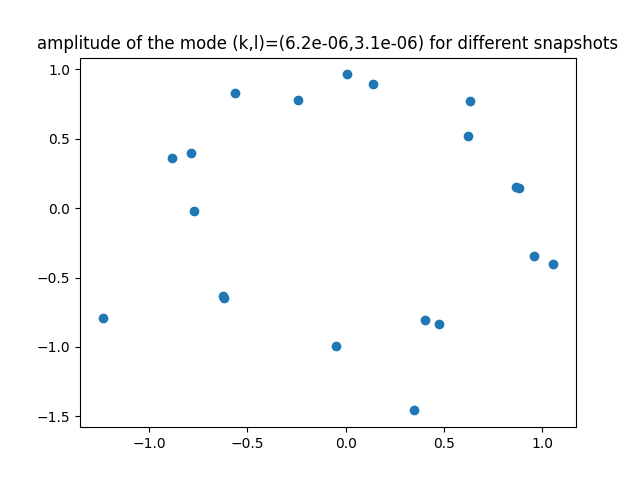

In [148]:
#Select time
time_sel_tab=np.arange(0,len(t),5)

k_test=k_found
l_test=l_found

real_part_tab,imag_part_tab=fft2d_RI(psi_lennard[:,:,:],k_test,l_test,Lx,nx,ny,time_sel_tab)

plt.figure()
plt.scatter(real_part_tab,imag_part_tab)
plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()

#print("the amplitude of the mode is ",np.mean(np.sqrt(real_part_tab**2+imag_part_tab**2))*(1/(np.pi*2)))

# fft_result = np.fft.fft2(psi_lennard[time_sel,:,:])

# fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

# #Calculating Energy
# energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2

# # Step 3: Plot the Spectrum

# plt.figure(figsize=(12, 6))
# plt.imshow(np.log(energy_spectrum +1e-5),  extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=-10,vmax=10)


# plt.colorbar(label='Log Energy')
# plt.xlabel('k')
# plt.ylabel('l')
# plt.title('Instantaneous Energy Spectrum in (k, l) Space')
# plt.show()


k_true 7.957747154594768e-07 l_true 3.183098861837907e-07
(20,)


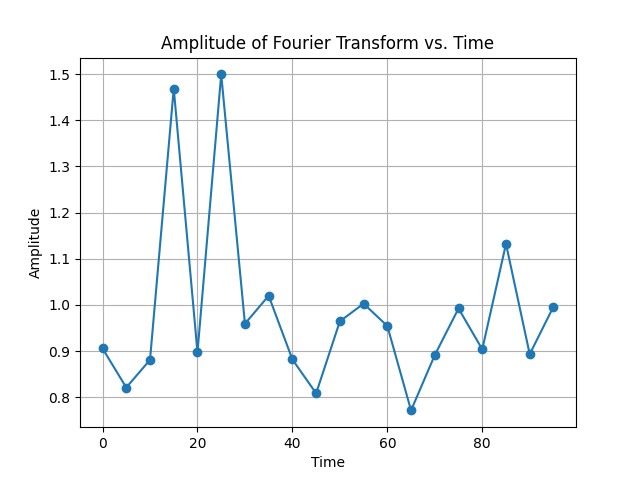

In [149]:
k_true=2.5/np.pi*10**(-6)
l_true=1/np.pi*10**(-6)
amplitude = np.sqrt(real_part_tab**2 + imag_part_tab**2)
print("k_true",k_true,"l_true",l_true)

print(time_sel_tab.shape)
plt.figure()
plt.plot(time_sel_tab, amplitude, marker='o')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Amplitude of Fourier Transform vs. Time')
plt.grid(True)
plt.show()

In [139]:
time_sel=2
kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
psi_fft = np.fft.fft2(psi_lennard[time_sel,:,:])
print(len(kx),len(ky))
#Finding the modes of the signal 
k_mode, l_mode = find_modes(psi_fft, kx,ky)
print(len(k_mode))

100 100
(2, 2)
2


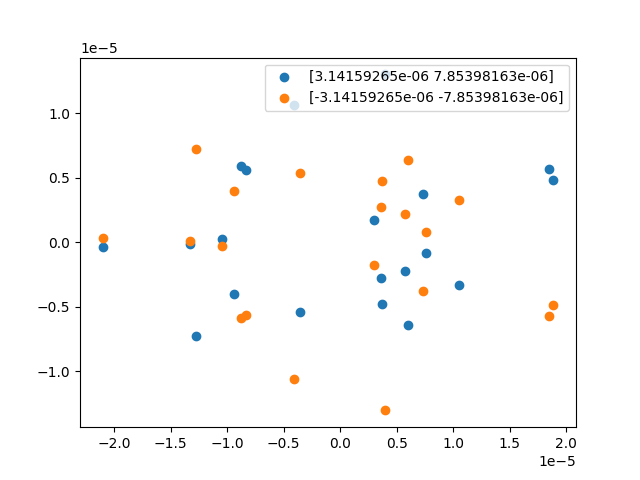

In [141]:
#This is a more appropriate code to  find the modes and not only the most energetic
kl_pairs = np.array(list(zip(k_mode, l_mode)))
epsilon=1e-3

plt.figure()
for pair in kl_pairs:
    real_part_tab,imag_part_tab=fft2d_RI(psi_lennard[:,:,:],pair[0],pair[1],Lx,nx,ny,time_sel_tab)
    amp=np.sqrt(real_part_tab**2+imag_part_tab**2)

    #Check if the mode has a constant amplitude over time
    if np.abs(np.max(amp) - np.min(amp)) <= epsilon:
        #Then, we plot it
        plt.scatter(real_part_tab,imag_part_tab,label=str(pair))
        plt.legend()

#plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()


In [150]:
#Determining the pulsation of the signal:

pulsation_observed=np.pi*2*pulsation(real_part_tab,imag_part_tab,t)
print(pulsation_observed)

-3.093269454559885e-06


In [151]:
#Finding beta
beta=-(k_test**2+l_test**2)*pulsation_observed/k_test
print("beta=",beta)
beta_true=2e-11
print("Beta error",np.abs(beta-beta_true)/beta_true*100,"%")

beta= 2.3808591855346653e-11
Beta error 19.04295927673327 %


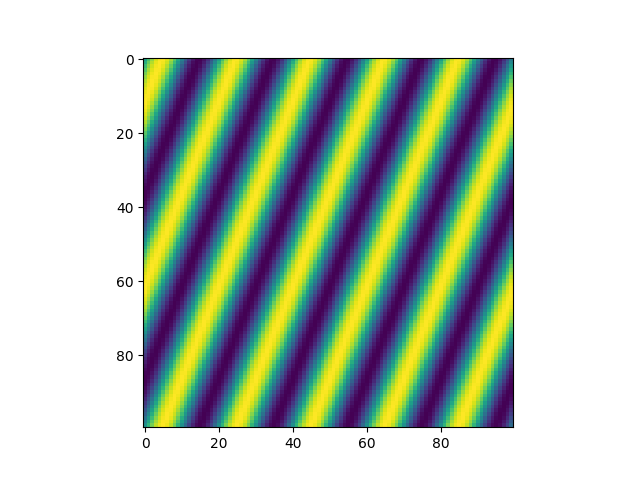

In [62]:
time_sel=1

plt.figure()
plt.imshow(psi_lennard[time_sel,:,:])
plt.show()

In [63]:
raise SystemExit("Stop here")

SystemExit: Stop here

/home/massoale/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Detecting waves for any field

#I will first find the most energetic modes


In [152]:
#Number of simulation
n=73

#choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file
if where=='local':
    if n<10:
        simu_name='outdir_000'+str(n)
    elif n<100 and n>=10:
        simu_name='outdir_00'+str(n)
    Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

elif where=='dahu':
    simu_name='dahu_'+str(n)
    Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()
print('la simulation chargée est: ' + simu_name )
print("depuis: "+where)

filenames=['/vars.nc']



dataset=nc.Dataset(Path+filenames[0])
print(dataset.variables.keys())

t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,0,:,:]
q=dataset.variables['q'][:,0,:,:]

print("psi shape",psi.shape)

#Lecture des paramètres :

param=io.read_params(Path)
print(param)
f0= param['f0']
beta=param['beta']
hEkb=param['hEkb']
dh=param['dh'][0]
Lx=param['Lx']
nx=param['NX']
ny=param['NY']
k_f=param['k_f']
sigma_f=param['sigma_f']
bc_fac=param['bc_fac']
nu_hyper=param['nu_hyper']
n_hyper=param['n_hyper']
dt_out=param['dt_out']

la simulation chargée est: dahu_73
depuis: dahu
dict_keys(['time', 'y', 'x', 'level', 'psi', 'q'])
psi shape (737, 512, 512)
{'NX': 512.0, 'NY': 512.0, 'nl': 1.0, 'Lx': 6.283185307179586, 'f0': 2.0, 'beta': 4.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-15, 'n_hyper': 6.0, 'hEkb': 2.2e-05, 'tend': 1576800000000.0, 'dt_out': 10.0}


In [153]:
time_tab=np.array([10])

nx=len(x)
ny=len(y)

k_max=np.pi*2/(x[1]-x[0])
k_min=2*np.pi/(x[-1]-x[0])

print("kmax=",k_max,"kmin=",k_min)

dx=x[1]-x[0]
dy=y[1]-y[0]
Lx=nx*dx


#k_max,l_max,amp_max=find_mode_max_amplitude(psi,Lx,nx,ny,time_tab)

kmax= 511.9999857523024 kmin= 1.0019569247862308


## Checking if it's a wave

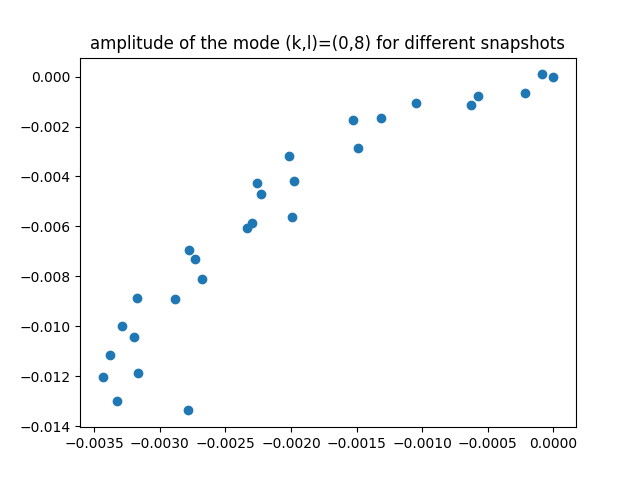

In [ ]:
#Select time
time_sel_tab=np.arange(0,len(t),5)

k_test=k_max
l_test=l_max

real_part_tab,imag_part_tab=fft2d_RI(psi[:,:,:],k_test,l_test,Lx,nx,ny,time_sel_tab)

plt.figure()
plt.scatter(real_part_tab,imag_part_tab,label='mode (k,l)=(32,0)')
plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()

(2, 148)
148


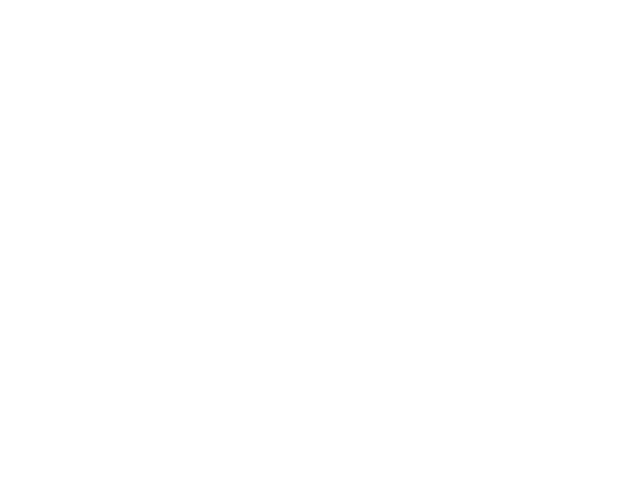

In [156]:
#Finding the modes out of the noise which could be candidates for Rossby waves

time_sel=1
kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
psi_fft = np.fft.fft2(psi[time_sel,:,:])


k_mode,l_mode=find_modes(psi_fft,kx,ky)


print(len(k_mode))
kl_pairs = np.array(list(zip(k_mode, l_mode)))
epsilon=0.01

plt.figure()
for pair in kl_pairs:
    real_part_tab,imag_part_tab=fft2d_RI(psi[:,:,:],pair[0],pair[1],Lx,nx,ny,time_sel_tab)
    amp=np.sqrt(real_part_tab**2+imag_part_tab**2)

    #Check if the mode has a constant amplitude over time
    if np.abs(np.max(amp) - np.min(amp)) <= epsilon:
        #Then, we plot it
        plt.scatter(real_part_tab,imag_part_tab)

#plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()


# Home-made Wave

In [ ]:
#Test avec une onde de Rossby


#Reading the netcdf file
dataset=nc.Dataset('rossby_wave.nc')
print(dataset.variables.keys())
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi_rossby=dataset.variables['psi'][:,:,:]
print(np.shape(psi_rossby))
t=dataset.variables['t'][:]


# Grid and time parameters
Lx=x[-1]-x[0]
nx=len(x)
ny=len(y)  



dict_keys(['x', 'y', 't', 'psi'])
(150, 256, 256)


In [ ]:
#Finding the mode with the maximum amplitude

time_tab=np.array([5])

k_found,l_found,amp_max=find_mode_max_amplitude(psi_rossby,Lx,nx,ny,time_tab)
print("k_max=",k_found,"l_max=",l_found," For an amplitude of",amp_max)


len k_range 258
k_min 0.9999999721724656
k_max 254.99999290397872


ValueError: attempt to get argmin of an empty sequence

In [ ]:
#Select time
time_sel_tab=np.arange(0,len(t),5)

k_test=k_found
l_test=l_found

real_part_tab,imag_part_tab=fft2d_RI(psi_rossby[:,:,:],k_test,l_test,Lx,nx,ny,time_sel_tab)

plt.figure()
plt.scatter(real_part_tab,imag_part_tab,label='mode (k,l)=(32,0)')
plt.title("amplitude of the mode (k,l)=("+str(f"{k_test:.2g}")+","+str(f"{l_test:.2g}")+") for different snapshots")
plt.show()


/home/massoale/.local/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)


ValueError: attempt to get argmin of an empty sequence

In [ ]:
#Determining the pulsation of the signal:

pulsation_observed=np.pi*2*pulsation(real_part_tab,imag_part_tab,t)
print(pulsation_observed)

1.0324996271539773


In [ ]:
#Finding beta
beta=(k_test**2+l_test**2)*pulsation_observed/k_test
print("beta=",beta)

beta= 9.218576198030228e-06


The homade wave was disgned originally with k=32,l=0 and beta= 4

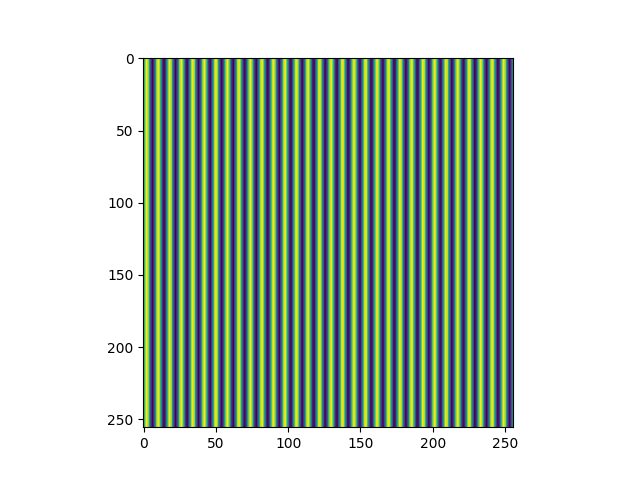

In [ ]:
#Plotting the wave
plt.figure()
plt.imshow(psi_rossby[1,:,:])
plt.show()